In [12]:
from IPython.display import YouTubeVideo

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [12,8]
%config IPCompleter.greedy=True

# RANS solver for fully developed turbulent channel flows
 
             Created on: Dec, 2018
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Gustavo J. Otero R. (G.J.OteroRodriguez@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.                     

## Define the mesh and matrices for the implicit solver 


    wall(BC)                                                wall(BC)
      y=0                                                     y=2H
       |                                                       |
       X ------ X ------ X ------ X ---    ...    --- X ------ X 
       |        |        |        |                   |        |     
      i=0       1        2        3                  n-2      n-1    

       

Inputs:
*   n ...        number of mesh points (nodes)
*   H ...       channel height
*   fact ...    factor to set mesh clustering at the wall
*   ns ...      number of stencil points in each direction

MESH class contains: 
  *  'y'      ... y coordinates  
  *  'ddy'    ... first derivative coefficient matrix d()/dy
  * 'd2dy2'  ... second derivative coefficient matrix d2()/dy2

In [24]:
import numpy as np
import math as m

        
def finiteDiffCoeff(x,k):

    x = np.array(x)
    n = np.size(x)
    A = np.ones((n,n))

    for i in range(1, n):
        A[i,:] = pow(x,i)/m.factorial(i)

    b = np.zeros((n,1))            # b is right hand side,
    b[k] = 1                       # so k'th derivative term remains
    sol = np.linalg.solve(A, b)   # solve system for coefficients
    return sol.transpose()


class Mesh:

    def __init__(self, n, H, fact, ns):
        
        self.nPoints = n

        di = 1.0/(n-1)
        i = (np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = H * (1.0 + np.tanh(fact*i)/m.tanh(fact/2))/2.0
        
        # coordinate transformation: derivative of y with respect to 'i'
        dydi =  H * fact/2.0/np.tanh(fact/2)/np.power(np.cosh(fact*i), 2.0)
        
        # coordinate transformation: second derivative of y with respect to 'i'
        d2ydi2 = -H * np.power(fact,2.0)/np.tanh(fact/2)*np.tanh(fact*i)/np.power(np.cosh(fact*i),2.0)
                
        # -------------------------------------------------------------
        # coefficient matrix for d()/dy
        # du/dy = 1/(dy/di) * du/di
        ddy = np.zeros((n,n))
        
        ddy[0,  0:7]   = finiteDiffCoeff(np.arange( 0,7), 1)
        ddy[1,  0:7]   = finiteDiffCoeff(np.arange(-1,6), 1)
        ddy[2,  0:7]   = finiteDiffCoeff(np.arange(-2,5), 1)
        ddy[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 1)
        ddy[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 1)
        ddy[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 1)
        
        for i in range(ns,n-ns):
            ddy[i,:] = 0.0
            ddy[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 1)
            
        # multiply coordinate transformation 
        for i in range(0,n):
            ddy[i,:] = ddy[i,:] * 1/di/dydi[i];
            
        self.ddy = ddy

        
        # -------------------------------------------------------------
        # coefficient matrix for d2()/dy2 (second derivative)
        # d2u/dy2 = 1/(dy/di)^2*d2u/di2 - 1/(dy/di)^3*d2y/di2*du/di
        d2dy2 = np.zeros((n,n))
        
        d2dy2[0,  0:7  ] = finiteDiffCoeff(np.arange( 0,7), 2)
        d2dy2[1,  0:7  ] = finiteDiffCoeff(np.arange(-1,6), 2)
        d2dy2[2,  0:7  ] = finiteDiffCoeff(np.arange(-2,5), 2)
        d2dy2[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 2)
        d2dy2[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 2)
        d2dy2[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 2)
        
        for i in range(ns,n-ns):
            d2dy2[i,:] = 0.0
            d2dy2[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 2)
        
        # multiply coordinate transformation 
        for i in range(0,n):
            d2dy2[i,:] = d2dy2[i,:]/np.power(di*dydi[i], 2.0) - ddy[i,:]*d2ydi2[i]/np.power(dydi[i],2)

        self.d2dy2 = d2dy2


### Check to solve laminar velocity profile for channel

Text(0, 0.5, 'Velocity u')

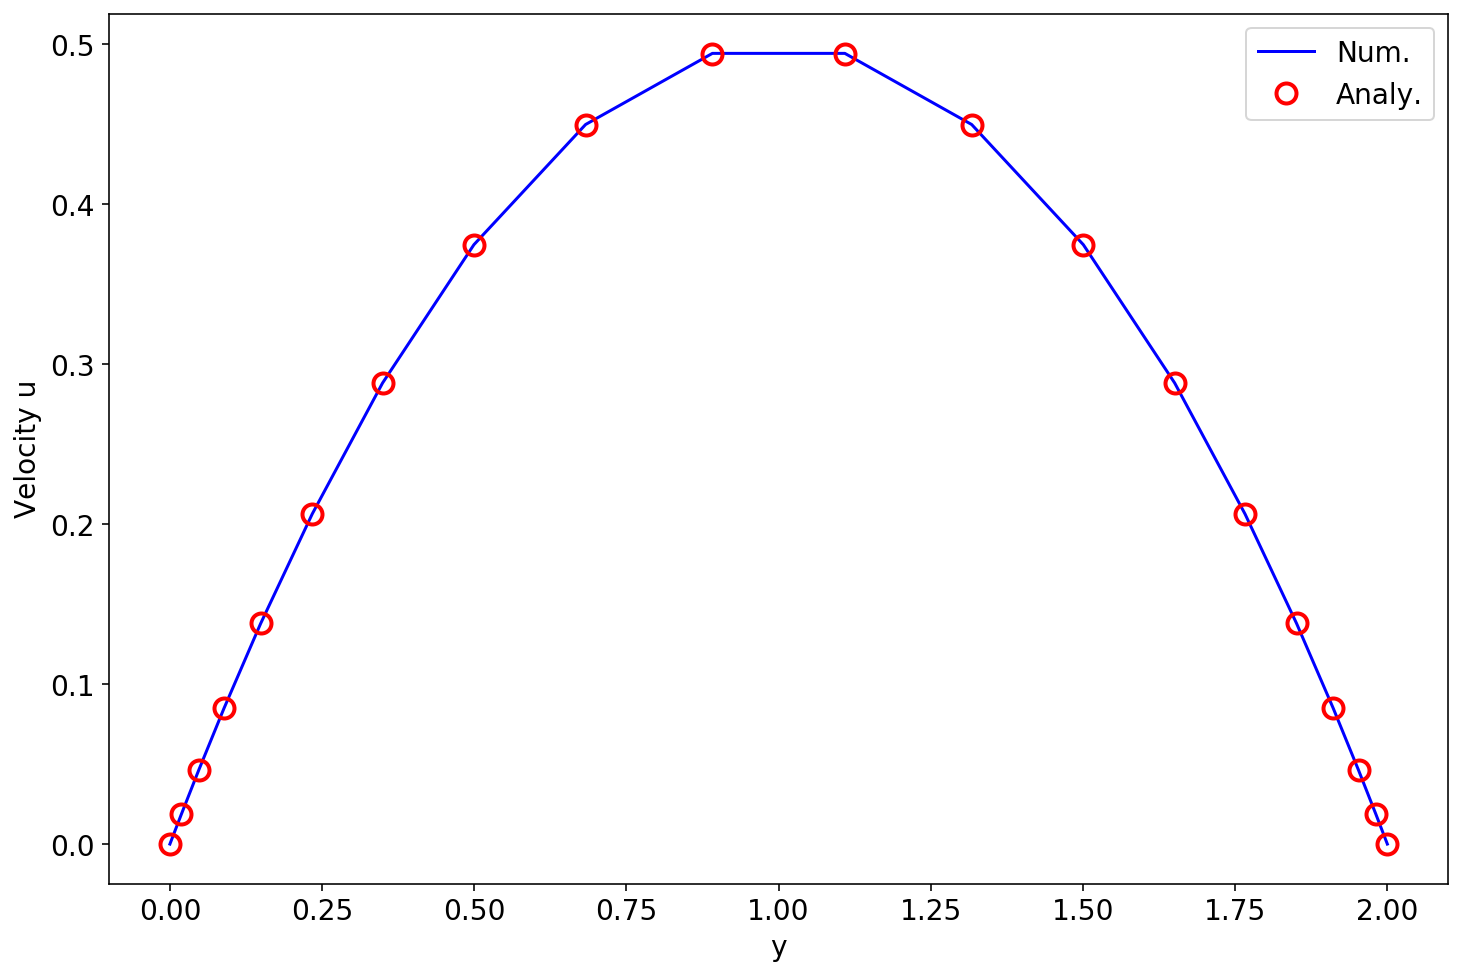

In [89]:
H = 1.0

mesh = Mesh(20, 2*H, 4.0, 2)  # mesh point, channel height, stretching factor, stencil

u = np.zeros(len(mesh.y))
u[1:-1] = np.linalg.solve(mesh.d2dy2[1:-1,1:-1], -np.ones(len(mesh.y)-2))

plt.plot(mesh.y, u, 'b-')
plt.plot(mesh.y, mesh.y*(H-0.5*mesh.y), 'ro',markersize=10,markeredgewidth = 2, markerfacecolor='none')
plt.legend(['Num.','Analy.'])
plt.xlabel('y')
plt.ylabel('Velocity u')

## Auxiliary function to solve linear system with under-relaxation

The linear system is
$$ Ax = b $$
Using an under-relaxation parameter $\omega$, the system can also be written as
$$ \left(A - \frac{1-\omega}{\omega}A_{ii}\right)x_{new} = b - \frac{1-\omega}{\omega}A_{ii}x_{old} $$


In [26]:
def solveEqn(x,A,b,omega):

    n = np.size(x)
    x_new = x.copy()
    
    # add boundary conditions
    b = b - x[0]*A[1:n-1,0] - x[n-1]*A[1:n-1,n-1]
    
    # perform under-relaxation
    b[:] = b[:] + (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
    np.fill_diagonal(A, A.diagonal()/omega)
    
    # solve linear system
    x_new[1:-1] = np.linalg.solve(A[1:-1, 1:-1], b)
    return x_new


## Momentum equation (fully developed channel)
The streamwise momentum equation of the Reynolds-averaged Navier-Stokes equations for a fully developed turbulent channel flow reads, 

$$ \frac{d}{dy}\left[\left(\mu+\mu_t \right) \frac{du}{dy}\right] = -1,$$ 

with $u$ the streamwise velocity, $\mu$ the dynamic visocity, and $\mu_t$ the Eddy viscosity which is obtained by a solving a turbulence model. Wall units are used to non-dimensionalize the Navier-Stokes equations, hence $-1$ defines the forcing on the right-hand-side. 
Using the product rule, the momentum equation can also be written as 
$$ \left[\frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2}\right] u = -1, $$ 

with $\mu_{eff} = \mu+\mu_t$. Now it is easy to formulate a linear system $ A u = -1 $ which can be solved using a direct linear solver. 

In [27]:
def solveRANS(r,mu):

    n    = mesh.nPoints
    u    = np.zeros(n)          # velocity 

    mut  = np.zeros(n)          # eddy viscosity     
    k    = 0.01*np.ones(n)      # turbulent kinetic energy
    e    = 0.001*np.ones(n)     # turbulent dissipation 
    
    residual   = 1.0e20
    iterations = 0
    
    print("Start iterating")

    while residual > 1.0e-6 and iterations < 10000:

        # Solve turbulence model to calculate eddy viscosity 
        mut,k,e = ke_model(u,k,e,r,mu,ReTau,mesh)

        # Solve momentum equation:  0 = d/dy[(mu+mut)dudy] - 1
        # diffusion matrix: mueff*d2phi/dy2 + dmueff/dy dphi/dy    
        A = np.einsum('i,ij->ij', mesh.ddy@(mu + mut), mesh.ddy) \
          + np.einsum('i,ij->ij', mu + mut, mesh.d2dy2)

        # Solve 
        u_old = u.copy()
        u[1:n-1] = np.linalg.solve(A[1:n-1, 1:n-1], -np.ones(n-2))
        residual = np.linalg.norm(u-u_old)/n

        # Printing residuals
        if iterations%100 == 0: print("iteration: ",iterations, ", Residual(u) = ", residual)
        iterations = iterations + 1

    print("iteration: ",iterations, ", Residual(u) = ", residual)
    
    return u, mut, k, e

### $k-\varepsilon$ turbulence model : 
We will implement the model of Myong, H.K. and Kasagi, N., "A new approach to the improvement of k-epsilon turbulence models for wall bounded shear flow", JSME, 1990.

Turbulent kinetic energy $k$:  $$ -\frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_k\right) \frac{d k}{dy}\right] = P_k - \rho \varepsilon $$
 Turbulent dissipation $\varepsilon$: $$ -\frac{d}{dy}\left[\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d \varepsilon}{dy}\right] = \frac{\varepsilon}{k}\left(C_{\varepsilon 1} P_k - C_{\varepsilon 2} f_2 \varepsilon\right) $$
 with the eddy viscosity $$ \mu_t = C_\mu f_\mu \rho \frac{k^2}{\varepsilon},$$ 
 the turbulent production 
 $$ P_k = \mu_t \left(\frac{du}{dy}\right)^2, $$
 the damping functions
 $$f_{mu} = \left(1+\frac{3.45}{\sqrt{Re_{turb}}}\right)\left(1-exp\left(-\frac{y^+}{70}\right)\right),$$
 $$ f_2 = \left[ 1-\frac{2}{9} exp\left(\frac{R^2_{turb}}{36}\right)\right]*\left(1-exp\left(-\frac{y^+}{5}\right)\right)^2,$$
and the constants
 $$C_{\mu} = 0.09,$$
 $$C_{\varepsilon1} = 1.4,$$
 $$C_{\varepsilon2} = 1.8,$$
 $${\sigma_k} = 1.4,$$
 $${\sigma_\varepsilon} = 1.3.$$
 The turbulent Reynolds number and the wall distance in viscous units are defined as: 
 $$Re_{turb} = \frac{\rho k^2}{\mu\varepsilon} ,$$
 $$y^+ = y Re_{\tau},$$
 where $Re_\tau$ is the desired Reynolds number based on the friction velocity and the channel half width. 
 
 The boundary conditions are 
 $$k_w = 0$$ 
 and 
 $$ \varepsilon_w = \left.\frac{\mu k}{\rho y^2}\right|_{\textrm{with values from the  first cell above the wall}} $$
 
 

## Solution approach: 
We are going to solve the $k$ and the $\varepsilon$ equations implicitly. To do this, we first need to apply the product rule on the diffusion term, such that a linear system of equations can easily be formulated. Second, we need to make the linear system of equations more "diagonal dominant", which means that we need to make the diagonal values in the matrix much larger than the off-diagonal terms. For example, the coefficients of the second derivative are [1 -2 1], so the diagonal is -2. Hence, we need to move positive terms from the right-hand-side (RHS) to the left-hand-side (LHS) where they will increase the diagonal dominance. 

The equation for $k$ then reads
$$ \left[\frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2} - \frac{\rho \varepsilon}{k}\right] k = -P_k $$
or formulated as a linear system of eqs
$$ \boldsymbol{A} k = -P_k$$ 
with 
$$ \boldsymbol{A} = \frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2} - \frac{\rho \varepsilon}{k} $$
and $$ mu_{eff} = \mu+\mu_{t}/\sigma_k. $$
As you can see, the term with the turbulent dissipation $\rho \varepsilon$ on the RHS of the $k$ equation has been moved to the LHS. But how can this be done, since $\rho \varepsilon$ does not directly depend on $k$? If we want to solve a linear systems of equations for $k$, we can only use terms on the LHS that directly depend on $k$. So, what we did is to multiply this term by $k/k$, such that we can add $\rho \varepsilon/k$ to the LHS. When multiplied with $k$, the original term is again obtained. 

Similarly, the $\varepsilon$ can be rewritten. 


In [28]:
def ke_model(u,k,e,r,mu,ReTau,mesh):

    n = mesh.nPoints
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    
    yplus = d*ReTau
    
    # HERE: Model constants 
    cmu  = 0.09 
    sigk = 1.4 
    sige = 1.3 
    Ce1  = 1.4 
    Ce2  = 1.8
    
    # HERE: Model functions 
    ReTurb  = r*np.power(k, 2)/(mu*e)
    f2      = (1-2/9*np.exp(-np.power(ReTurb/6, 2)))*np.power(1-np.exp(-yplus/5), 2)
    fmue    = (1-np.exp(-yplus/70))*(1.0+3.45/np.power(ReTurb, 0.5))
    fmue[0] = fmue[-1] = 0.0
    
    # HERE: eddy viscosity and turbulent production Pk = mut*dudy^2.
    #       The velocity gradient can simply be obtained using "mesh.ddy@u"
    mut = cmu*fmue*r/e*np.power(k,2)
    Pk  = mut*np.power(mesh.ddy@u,2)

    # ---------------------------------------------------------------------
    # HERE: e-equation
    
    # effective viscosity
    mueff = mu + mut/sige

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy (see above)
    A = np.einsum('i,ij->ij',  mueff, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff), mesh.ddy)

    # Left-hand-side, implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - Ce2*f2*r*e/k)

    # Right-hand-side
    b = - e[1:-1]/k[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu[ 0]/r[ 0]*k[ 1]/np.power(d[ 1], 2)
    e[-1] = mu[-1]/r[-1]*k[-2]/np.power(d[-2], 2)

    # Solve eps equation
    e = solveEqn(e, A, b, 0.6)
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # k-equation

    # effective viscosity
    mueff = mu + mut/sigk

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij',  mueff, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff), mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - r*e/k)
    
    # Right-hand-side
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve TKE
    k = solveEqn(k, A, b, 0.6)
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,e

# Call main RANS solver
first get DNS data and create mesh for RANS

In [85]:
import linecache

mesh = Mesh(150, 2, 4, 2)  # mesh point, channel height, stretching factor, stencil

# get parameters from DNS or set these parameters (they must be defined)
ReTau  = 390

yplus = ReTau * mesh.y[1]

print('yplus value is: ', yplus)

r = np.ones(mesh.nPoints)
mu = np.ones(mesh.nPoints)/ReTau

u,mut,k,e = solveRANS(r,mu)

yplus value is:  0.7874926968340978
Start iterating
iteration:  0 , Residual(u) =  2.500779837405157
iteration:  100 , Residual(u) =  0.00307202677893945


/Users/rpecnik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/rpecnik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
/Users/rpecnik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/rpecnik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


iteration:  200 , Residual(u) =  0.0006234294677190005
iteration:  300 , Residual(u) =  0.00022549277643641428
iteration:  400 , Residual(u) =  0.0001189576524173523
iteration:  500 , Residual(u) =  6.14935064581647e-05
iteration:  600 , Residual(u) =  2.9142367640892166e-05
iteration:  700 , Residual(u) =  1.3556543201074277e-05
iteration:  800 , Residual(u) =  6.339076123208279e-06
iteration:  900 , Residual(u) =  3.00682044547044e-06
iteration:  1000 , Residual(u) =  1.450137981349165e-06
iteration:  1053 , Residual(u) =  9.987527785545426e-07


### Plot results

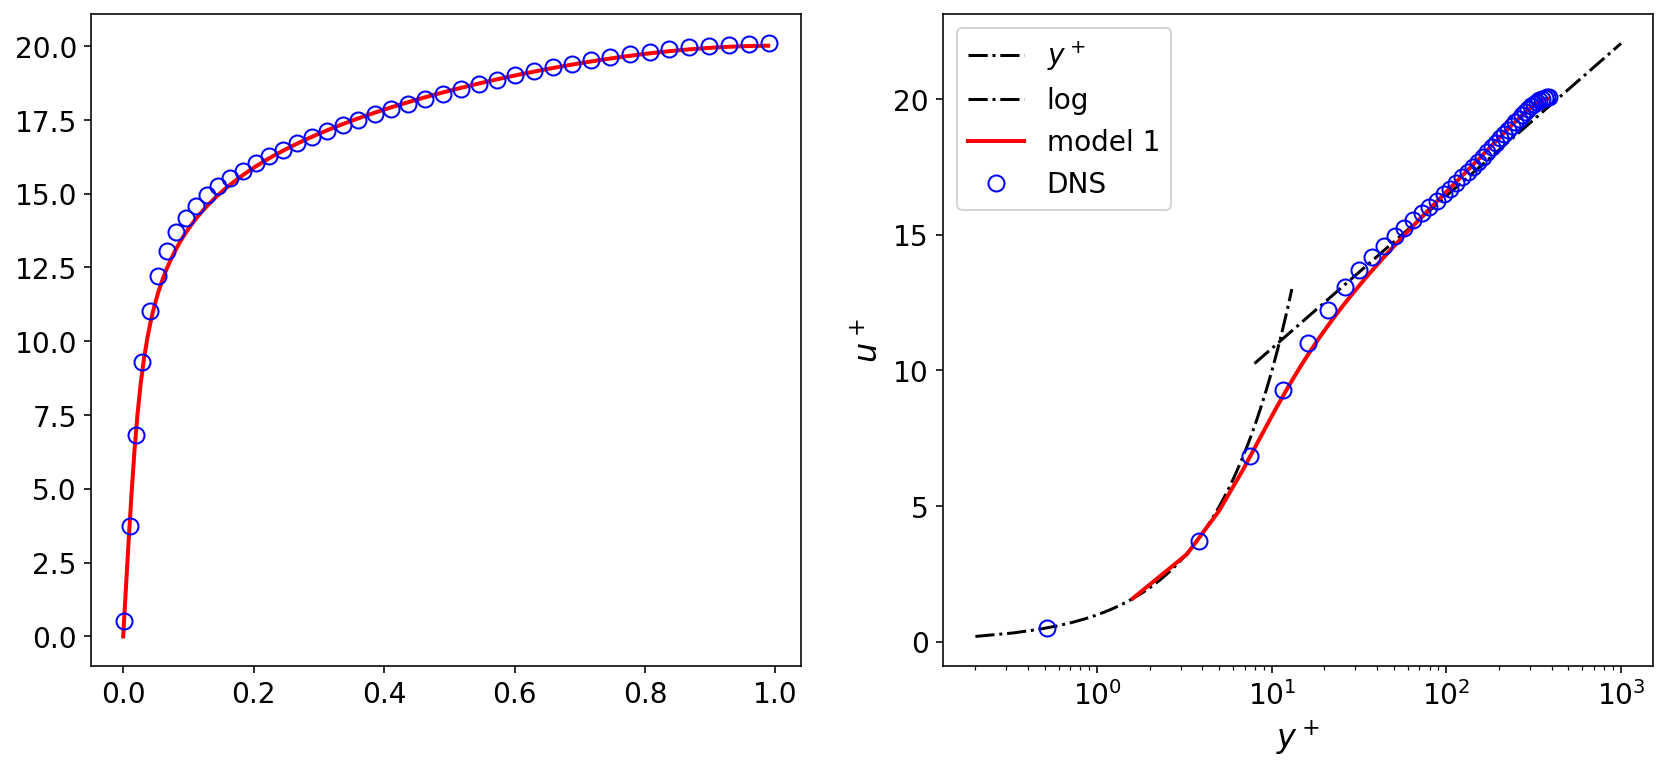

In [83]:
n = mesh.nPoints

# load dns data
DNS = np.loadtxt("DNS_data/constProperty.txt",skiprows=88)


fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].plot(mesh.y[0:n//2], u[0:n//2],'r',linewidth=2)
ax[0].plot(DNS[::3,1]/DNS[-1,1],DNS[::3,8],'bo',fillstyle='none',lw=4, ms=8)

# analytic results for viscous sub-layer
ypLam = np.linspace(0.2,13,100); 
ax[1].semilogx(ypLam,ypLam,'k-.')
    
# semi-empirical result for log-layer
ypTurb = np.linspace(0.9,3,20); 
upTurb = 1/0.41*np.log(np.power(10, ypTurb))+5.2
ax[1].plot(np.power(10, ypTurb), upTurb,'k-.')

# model solution
line1 = plt.plot(mesh.y[1:n//2]*ReTau,u[1:n//2], 'r-',lw=2)
line3 = plt.plot(DNS[::3,1],DNS[::3,8],'bo',fillstyle='none',lw=4, ms=8)
ax[1].set_xlabel('$y^+$', fontsize=16); plt.ylabel('$u^+$', fontsize=16);
ax[1].legend(('$y^+$','log','model 1', 'DNS'))
